In [9]:
# Cell 1: Import Libraries

# Basics
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Import the core pinecone library (using the v3+ class)
import pinecone
from pinecone import Pinecone, ServerlessSpec # Or PodSpec if not serverless
import time # Needed for waiting for index creation

# LangChain Components (using modern import paths >= 0.1.0)

# LLM (Use ChatOpenAI for most modern tasks)
from langchain_openai import ChatOpenAI
# If you specifically need the older completion endpoint:
# from langchain_openai import OpenAI

# Document Loader (correct path)
from langchain.document_loaders import PyPDFLoader

# Splitter (correct path)
from langchain.text_splitter import RecursiveCharacterTextSplitter
# Need tiktoken for accurate token counting with OpenAI models
import tiktoken

# Tokenizer (external library - correct path for transformers, if still needed)
# from transformers import GPT2TokenizerFast # Keep if you specifically use this tokenizer later

# Embedding (using modern import path)
from langchain_openai import OpenAIEmbeddings

# Vector Store (using modern import path for Pinecone)
from langchain_pinecone import PineconeVectorStore
# For FAISS (location might vary slightly, but often in community):
# from langchain_community.vectorstores import FAISS # If using FAISS locally

# Imports for modern RAG chain construction (LCEL and utility chains)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder # For building prompts
from langchain_core.runnables import RunnablePassthrough, RunnableParallel # For composing chains
from langchain_core.output_parsers import StrOutputParser # For parsing output
from langchain.chains import create_history_aware_retriever, create_retrieval_chain # Utility chain constructors
from langchain.chains.combine_documents import create_stuff_documents_chain # Needed for combining docs
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage # For handling chat history messages

print("Libraries imported. Note: Ensure you have run `pip install ...` for the latest versions.")

Libraries imported. Note: Ensure you have run `pip install ...` for the latest versions.


In [6]:
# Cell 2: Load Environment Variables

# Load environment variables from a .env file
# Make sure you have a .env file in your project root
# with variables like:
# OPENAI_API_KEY="your-openai-api-key"
# PINECONE_API_KEY="your-pinecone-api-key"
# PINECONE_ENVIRONMENT="your-pinecone-environment" # e.g., "us-east-1-aws"
# PINECONE_INDEX_NAME="your-index-name"         # Your chosen index name

# Imports (os, load_dotenv) already in Cell 1

load_dotenv()

# Get API keys and environment from environment variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_ENVIRONMENT = os.getenv("PINECONE_ENVIRONMENT")
PINECONE_INDEX_NAME = os.getenv("PINECONE_INDEX_NAME")

# Basic check to ensure variables are loaded
if not all([OPENAI_API_KEY, PINECONE_API_KEY, PINECONE_ENVIRONMENT, PINECONE_INDEX_NAME]):
    raise ValueError("Ensure OPENAI_API_KEY, PINECONE_API_KEY, PINECONE_ENVIRONMENT, and PINECONE_INDEX_NAME are set in your environment variables or .env file")

print("Environment variables loaded successfully.")
# Avoid printing sensitive keys directly in notebook output for security
# print(f"OpenAI Key Loaded: {bool(OPENAI_API_KEY)}")
# print(f"Pinecone Key Loaded: {bool(PINECONE_API_KEY)}")
# print(f"Pinecone Environment: {PINECONE_ENVIRONMENT}")
# print(f"Pinecone Index Name: {PINECONE_INDEX_NAME}")

Environment variables loaded successfully.



# PART 1: LANGCHAIN BASICS


🎯 **Objective:** Understand what is the LangChain library and all the elements that are required to generate a simple pipeline to query out documents. 

### **What is LangChain?**
> LangChain is a framework for developing applications powered by language models.

LangChain makes the hardest parts of working with AI models easier in two main ways:

1. **Data-aware** - Bring external data, such as your files, other applications, and API data, to your LLMs
2. **Agentic** - Allow your LLMs to interact with it's environment via decision making. Use LLMs to help decide which action to take next. 

### **Why LangChain?**
1. **Components** - Abstractions for working with language models, along with a collection of implementations for each abstraction. Components are modular and easy-to-use, whether you are using the rest of the LangChain framework or not

2. **Chains** - LangChain provides out of the box support for using and customizing 'chains' - a series of actions strung together. A structured assembly of components for accomplishing specific higher-level tasks.

3. **Speed 🚢** - This team ships insanely fast. You'll be up to date with the latest LLM features.

4. **Community 👥** - Wonderful discord and community support, meet ups, hackathons, etc.

Though the usage of LLMs can be straightforward (text-in, text-out), when trying to build complex applications you'll quickly notice friction points. 

> LangChain helps with once you develop more complicated application and manage LLMs the way we want. 

In [ ]:
#  Test Basic LLM Call (using modern ChatOpenAI)

# LLM (import already in Cell 1)
# from langchain_openai import ChatOpenAI

# Ensure OPENAI_API_KEY is loaded from Cell 2

# Initialize the Chat LLM
print("Initializing ChatOpenAI model for basic test...")
chatgpt = ChatOpenAI(
    model="gpt-3.5-turbo",  # Specify the model name
    temperature=0,          # Temperature controls randomness
    openai_api_key=OPENAI_API_KEY # Pass the API key directly
)
print("ChatOpenAI model initialized.")

# Define a simple prompt
prompt = "Please, tell me some funny jokes"
print(f"\nSending prompt to LLM: '{prompt}'")

# Invoke the LLM with the prompt
# The invoke method is the standard way to call Runnables (like LLMs)
response = chatgpt.invoke(prompt)

# Print the response
print("\nLLM Response:")
print(response.content) # Access the content attribute for the string response

Initializing ChatOpenAI model for basic test...
ChatOpenAI model initialized.

Sending prompt to LLM: 'Please, tell me some funny jokes'

LLM Response:
Sure, here are a few jokes for you:

1. Why couldn't the bicycle stand up by itself? Because it was two tired!
2. Why did the tomato turn red? Because it saw the salad dressing!
3. What do you call a bear with no teeth? A gummy bear!
4. Why did the math book look sad? Because it had too many problems.
5. How does a penguin build its house? Igloos it together!

I hope these jokes brought a smile to your face!


### **Chat Messages**
LangChain allows us to segmentate prompts into three main types.(System, Human, AI)

* **System** - Helpful background context that tell the AI its high-level behavior.
* **Human** - Messages that represent the user input. 
* **AI** - Messages that show the response of the AI model, they work as examples to the model. 


For more, see OpenAI's [documentation](https://platform.openai.com/docs/guides/chat/introduction)

In [10]:
#  Basic Chat Model Interaction

# LLM (import already in Cell 1)
# from langchain_openai import ChatOpenAI
# Message types (imports already in Cell 1)
# from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Ensure OPENAI_API_KEY is loaded from Cell 2

# Initialize the Chat LLM
print("Initializing ChatOpenAI model for message interaction...")
# The model name is already set to "gpt-3.5-turbo" in the original code
chatgpt = ChatOpenAI(
    model="gpt-3.5-turbo", # Specify the model name
    temperature=0,         # Temperature controls randomness
    openai_api_key=OPENAI_API_KEY # Pass the API key directly
)
print("ChatOpenAI model initialized.")

# Define the desired high-level behavior using a SystemMessage
high_level_behavior = """
You are an AI bot that help people decide where to travel.
Always recommend three destination with a short sentence for each.
"""

# Define the conversation history as a list of message objects
# Use the imported message classes (SystemMessage, AIMessage, HumanMessage)
messages = [
    SystemMessage(content=high_level_behavior),
    AIMessage(content="Hello! I am a traveller assistant, how can I help you?"),
    HumanMessage(content="Where should I travel next?"),
]

print("\nSending messages to LLM:")
for msg in messages:
    print(f"- {msg.type.capitalize()}: {msg.content}")

# Invoke the LLM with the list of messages
# The invoke method is the standard way to call Chat Models
response = chatgpt.invoke(messages)

# The response is a BaseMessage object (an AIMessage in this case)
# Access the content attribute for the string response
print("\nLLM Response:")
print(response.content)

Initializing ChatOpenAI model for message interaction...
ChatOpenAI model initialized.

Sending messages to LLM:
- System: 
You are an AI bot that help people decide where to travel.
Always recommend three destination with a short sentence for each.

- Ai: Hello! I am a traveller assistant, how can I help you?
- Human: Where should I travel next?

LLM Response:
Here are three destination recommendations for you:

1. **Kyoto, Japan**: Immerse yourself in the rich history and culture of Kyoto by exploring its ancient temples, traditional tea houses, and beautiful gardens.
   
2. **Barcelona, Spain**: Experience the vibrant energy of Barcelona with its stunning architecture, delicious cuisine, and lively street performances.
   
3. **Banff National Park, Canada**: Surround yourself with the breathtaking beauty of the Canadian Rockies in Banff National Park, where you can hike, ski, and relax in natural hot springs.


You can also pass more chat history with responses from the AI

In [11]:
# Continuing Basic Chat Interaction

# Define the desired high-level behavior using a SystemMessage (re-defined for clarity in this cell)
high_level_behavior = """
You are an AI bot that help people decide where to travel.
Always recommend three destination with a short sentence for each.
"""

# Define the extended conversation history as a list of message objects
# This list includes the previous turns and the new interaction
messages = [
    SystemMessage(content=high_level_behavior),
    AIMessage(content="Hello! I am a traveller assistant, how can I help you?"),
    HumanMessage(content="Where should I travel next?"),
    AIMessage(content="For your next travel destination, consider:\n1. Kyoto, Japan: Immerse yourself in ancient temples and serene gardens.\n2. Florence, Italy: Explore Renaissance art and historic architecture.\n3. Banff, Canada: Experience breathtaking mountain landscapes and outdoor activities."), # <--- Added AI response from previous turn
    HumanMessage(content="I love going to Museums?"), # <--- Added the new Human message
]

print("\nSending extended messages to LLM:")
for msg in messages:
    print(f"- {msg.type.capitalize()}: {msg.content}")


# Invoke the LLM with the extended list of messages
# The invoke method is the standard way to call Chat Models
response = chatgpt.invoke(messages)

# The response is a BaseMessage object (an AIMessage in this case)
# Access the content attribute for the string response
print("\nLLM Response:")
print(response.content)


Sending extended messages to LLM:
- System: 
You are an AI bot that help people decide where to travel.
Always recommend three destination with a short sentence for each.

- Ai: Hello! I am a traveller assistant, how can I help you?
- Human: Where should I travel next?
- Ai: For your next travel destination, consider:
1. Kyoto, Japan: Immerse yourself in ancient temples and serene gardens.
2. Florence, Italy: Explore Renaissance art and historic architecture.
3. Banff, Canada: Experience breathtaking mountain landscapes and outdoor activities.
- Human: I love going to Museums?

LLM Response:
If you love museums, you might enjoy visiting:
1. Paris, France: Home to world-class museums like the Louvre and Musée d'Orsay.
2. New York City, USA: Explore the Metropolitan Museum of Art and the Museum of Modern Art.
3. St. Petersburg, Russia: Discover the State Hermitage Museum and the Fabergé Museum.


### **Text Embedding Model**

When documents or string-variables are too long, things got quite complicated. 

**In order to be able to process them, we can embed and convert string variables into vectors** (a series of numbers that hold the semantic 'meaning' of your text).

*What are embeddings?*

To put it simple, a number representation of your text. This list of numbers contains the information about the meaning of the text, so we can find similar text with similar meaning by seeing their number representation. 

Mainly used when comparing different pieces of text or when dealing with huge texts. 

**TASK:**
- First import the `Embeddings` model from langcgain.embeddings.
- Define a text to embed. 
- Embed the text with the `.embed_query` command. 

In [12]:
# Cell 5 (Actual): Testing OpenAI Embeddings

# Import necessary components for this cell (already in Cell 1)
# from langchain_openai import OpenAIEmbeddings

# Ensure OPENAI_API_KEY is loaded from Cell 2

# 1. Initialize an instance of the OpenAI Embeddings model
print("Initializing OpenAI Embeddings model for testing...")
embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002", # Specify the model name (standard and recommended)
    openai_api_key=OPENAI_API_KEY    # Pass the API key directly
)
print("Embeddings model initialized.")

# 2. Define a text to embed
text = "Hi! It's time to go to a Museum!"
print(f"\nText to embed: \"{text}\"")

# 3. Embed the text using the model
# Use the embed_query method for embedding a single piece of text intended for querying
text_embedding = embeddings.embed_query(text)

# 4. Print information about the embedding
print(f"Your embedding is length {len(text_embedding)}")
print(f"Here's a sample of the vector (first 5 elements): {text_embedding[:5]}...")
# The length should be 1536 for the text-embedding-ada-002 model

Initializing OpenAI Embeddings model for testing...
Embeddings model initialized.

Text to embed: "Hi! It's time to go to a Museum!"
Your embedding is length 1536
Here's a sample of the vector (first 5 elements): [-0.0022889249958097935, -0.003987872041761875, -0.001093194354325533, -0.01741538941860199, -0.021277064457535744]...


### **Chains**

Conversation chains in the context of Langchain are a concept involving the sequential linking of multiple conversational elements to build complex interactions. The idea is to streamline and enhance the conversation flow.

The most basic chain is the `ConversationChain`. However, we will use the `load_qa_chain` to query questions about our documents, as its main function is optimized for this task. 

You can go check all available chains in the [LangChain Documentation.](https://python.langchain.com/docs/modules/chains/)

In [13]:
# Basic Conversation Chain

# Import necessary components for this cell (already in Cell 1)
# from langchain.chains import ConversationChain # Original import path

# Ensure `llm` (ChatOpenAI) is initialized from a previous cell (e.g., Cell 3)

print("Initializing Basic Conversation Chain...")

# Initialize the ConversationChain
# Pass your Chat LLM instance to the chain
# Note: ConversationChain is an older chain type. For RAG with conversation history,
# the LCEL approach using create_history_aware_retriever is recommended.
# However, we'll update this cell to use the modern import path for ConversationChain
from langchain.chains.conversation.base import ConversationChain # Modern import path for ConversationChain

conversation = ConversationChain(llm=chatgpt)

# Run a turn in the conversation
# Use the invoke method, passing the user input directly
print("\nRunning conversation.invoke('Hello!')")
response = conversation.invoke("Hello!")

# The response is a dictionary, often containing 'response' or 'output' key
# Check the output structure if needed
# print(response)

print("\nAI Response:")
# Access the response text - check the dictionary keys based on the chain output
# For ConversationChain.invoke, the output key is typically 'response'
print(response.get('response'))

# You can run another turn by invoking the chain again
# print("\nRunning conversation.invoke('How are you today?')")
# response2 = conversation.invoke("How are you today?")
# print("\nAI Response:")
# print(response2.get('response'))

Initializing Basic Conversation Chain...

Running conversation.invoke('Hello!')


C:\Users\Nainesh Rathod\AppData\Local\Temp\ipykernel_26868\2629095289.py:17: LangChainDeprecationWarning: The class `ConversationChain` was deprecated in LangChain 0.2.7 and will be removed in 1.0. Use :meth:`~RunnableWithMessageHistory: https://python.langchain.com/v0.2/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html` instead.
  conversation = ConversationChain(llm=chatgpt)
d:\data\document_chatbot\venve\Lib\site-packages\pydantic\main.py:253: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)



AI Response:
Hello! How are you today?


### Memory
When interacting with a model, it is important to keep track of all interactions performed with it. 

To overcome these limitations, langchain implements different types of memories to use in your application.

It is important to consider that storing all the interactions with the model can quickly escalate to a considerable amount of tokens to process every time we prompt the model. It is essential to bear in mind that ChatGPT has a token limit per interaction.

You can learn more about memory [here]([https://towardsdatascience.com/custom-memory-for-chatgpt-api-artificial-intelligence-python-722d627d4d6d])



In [14]:
# Cell 7 (Actual): Demonstrating Conversation Memory and Basic Conversation Chain with Memory

# Import necessary components for this cell (imports already in Cell 1)
# from langchain.memory import ConversationSummaryBufferMemory # Original import path
# from langchain.chains import ConversationChain # Original import path
# from langchain_openai import ChatOpenAI # LLM import

# Ensure OPENAI_API_KEY is loaded from Cell 2
# Ensure `llm` (ChatOpenAI) is initialized from a previous cell (e.g., Cell 3 or 4)

# Modern import path for ConversationSummaryBufferMemory
from langchain.memory import ConversationSummaryBufferMemory

# Modern import path for ConversationChain (used in Cell 6)
from langchain.chains.conversation.base import ConversationChain

# 1. Initialize Conversation Summary Buffer Memory

print("Initializing ConversationSummaryBufferMemory...")
# Pass your Chat LLM instance for summarization and set the max token limit
memory = ConversationSummaryBufferMemory(
    llm=chatgpt, # The LLM used for summarizing older messages
    max_token_limit=100, # Max number of tokens to store in the buffer before summarizing
    memory_key="history", # Key for the history variable (can be anything, but "history" is common)
    return_messages=True # Return history as a list of message objects
)
print("Memory initialized.")

# 2. Manually Save Context to Memory

print("\nManually saving context to memory...")
# Use the .save_context() method to add a turn (input/output pair) to memory
# The method expects dictionaries for the input and output of a conversational turn
memory.save_context(
    {"input":  "Can you recommend me where should I travel next?"},
    {"output": "Hello! I am a traveller assistant, sure I can help you. What do you enjoy doing?"}
)

memory.save_context(
    {"input":  "I love going to Museums"},
    {"output": "Great then you should go to a cultural capital."}
)
print("Context saved.")

# You can check the current state of the memory (optional)
# print("\nCurrent state of memory:")
# print(memory.load_memory_variables({}))

# 3. (Re)initialize ChatOpenAI (assuming you might want to re-initialize here per original notebook)
# If llm was already initialized in a prior cell, this might be redundant,
# but following the notebook's sequence:
# Note: Ensure OPENAI_API_KEY is defined (from Cell 2)
print("\n(Re)initializing ChatOpenAI model...")
chatgpt_for_chain = ChatOpenAI( # Use a different variable name if llm is still in use
    model="gpt-3.5-turbo",
    temperature=0,
    openai_api_key=OPENAI_API_KEY # Pass API key
)
print("ChatOpenAI model initialized.")


# 4. Initialize ConversationChain with Memory

print("\nInitializing ConversationChain with Memory...")
conversation = ConversationChain(
    llm=chatgpt_for_chain, # Use the LLM instance
    memory=memory,         # Pass the initialized memory object
    verbose=True           # Set verbose=True to see the prompts being sent to the LLM
)
print("ConversationChain initialized.")

# 5. Run a Conversational Turn using the Chain

user_input = "What cities do you recommend me?"
print(f"\nRunning conversation.invoke('{user_input}')")

# Use the .invoke() method to run a turn in the conversation chain
# Pass the user input as a string (ConversationChain is designed for simple string input/output)
response = conversation.invoke(user_input)

# The response from ConversationChain.invoke is a dictionary
# The final AI response is typically under the key 'response'
print("\nAI Response:")
print(response.get('response')) # Use .get() for safe access

Initializing ConversationSummaryBufferMemory...
Memory initialized.

Manually saving context to memory...
Context saved.

(Re)initializing ChatOpenAI model...


C:\Users\Nainesh Rathod\AppData\Local\Temp\ipykernel_26868\2795672115.py:21: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationSummaryBufferMemory(


ChatOpenAI model initialized.

Initializing ConversationChain with Memory...
ConversationChain initialized.

Running conversation.invoke('What cities do you recommend me?')


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
[HumanMessage(content='Can you recommend me where should I travel next?', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello! I am a traveller assistant, sure I can help you. What do you enjoy doing?', additional_kwargs={}, response_metadata={}), HumanMessage(content='I love going to Museums', additional_kwargs={}, response_metadata={}), AIMessage(content='Great then you should go to a cultural capital.', additional_kwargs={}, response_metadata={})]
Human: What cities do you recom

### Dealing with Documents

We are here to deal with documents... so LangChain provides a wide variety of elements to deal with them. 

One of the most important improvements of LangChain is that it allows us to upload documents and pass them to our model. 
We consider a document as an object that holds a piece of text and metadata (more information about that text)

- Document class
- Document Loader
- Document Retriever
- Text Splitter
- Index

**TASK**

1. From langchain.schema import the `Document` class. 
2. Now define a document that has 
   - Text contained in page_content. 
   - Metada composed of document_id, document_source and document_create_time. 

In [15]:
# Cell 8 (Actual): Demonstrating the Document Object

# Import the Document class (import already in Cell 1)
# from langchain.schema import Document # Original import path

# Modern import path for the Document class
from langchain_core.documents import Document

print("Demonstrating the Document object structure.")

# 1. Define the content and metadata for the document
page_content = "Let's imagine this is a huge document with a lot of words and important stuff."
metadata = {
    'document_id' : '0000', # Changed to string as IDs often are
    'document_source' : "my_source.pdf",
    'document_create_time' : "01/01/2000"
}

# 2. Create an instance of the Document object
document = Document(page_content=page_content, metadata=metadata)

# Print the document object
print("\nCreated Document object:")
print(document)

# You can access its attributes
print(f"\nPage Content: {document.page_content}")
print(f"Metadata: {document.metadata}")

Demonstrating the Document object structure.

Created Document object:
page_content='Let's imagine this is a huge document with a lot of words and important stuff.' metadata={'document_id': '0000', 'document_source': 'my_source.pdf', 'document_create_time': '01/01/2000'}

Page Content: Let's imagine this is a huge document with a lot of words and important stuff.
Metadata: {'document_id': '0000', 'document_source': 'my_source.pdf', 'document_create_time': '01/01/2000'}


#### Document Loaders

Depending on where our data is stored, we will need a different type of loader:

- The **Online Loader** is used for loading a document directly from the Internet. LangChain implements different types of loaders. For example, there is the `WikipediaLoader` that helps you loading Wikipedia pages or the `HNLoader` to take content directly from any HackerNews page.



- The **Offline Loader** is used loading a document stored that are already installed in your machine. There are also different types of offline loaders such as the **HTML** loader for `.html` pages or the **PyPDFLoader** for `.pdf` documents.

In this tutorial, we will see an example of Online Loader by using the `WikipediaLoader` and the `HNLoader`, and an example of Offline Loader by using the PyPDFLoader.

You can find a list of the supported [LangChain Document Loaders](https://python.langchain.com/docs/integrations/document_loaders) in the official documentation. Those Loaders are from external integrations, [native LangChain Loaders](https://python.langchain.com/docs/modules/data_connection/document_loaders/) can be found in the official documentation as well.

In [16]:
# Cell 9 (Actual): Loading Data with WikipediaLoader

# Import necessary components for this cell (import in Cell 1 was for PyPDFLoader)
# The WikipediaLoader is part of the langchain-community package in modern versions
from langchain_community.document_loaders import WikipediaLoader

print("Demonstrating loading data from Wikipedia.")

# Define the topic to load from Wikipedia
topic = "Machine_learning"
print(f"Loading content for topic: '{topic}' from Wikipedia...")

# Initialize the WikipediaLoader
loader = WikipediaLoader(topic)

# Load content from Wikipedia. This returns a list of Document objects.
# Each Document might represent a section or chunk of the Wikipedia page.
try:
    wikipedia_data = loader.load()
    print(f"Successfully loaded {len(wikipedia_data)} documents from Wikipedia.")

    # Display the first document loaded
    if wikipedia_data:
        print("\nContent of the first Wikipedia document:")
        # print(wikipedia_data[0]) # Print the whole Document object
        print(f"Source: {wikipedia_data[0].metadata.get('source')}")
        print(f"Title: {wikipedia_data[0].metadata.get('title')}")
        print(f"Summary: {wikipedia_data[0].page_content[:500]}...") # Print first 500 chars
    else:
        print("No data was loaded from Wikipedia.")

except Exception as e:
    print(f"Error loading data from Wikipedia: {e}")
    print("Please ensure you have the 'wikipedia' library installed (`pip install wikipedia`)")

Demonstrating loading data from Wikipedia.
Loading content for topic: 'Machine_learning' from Wikipedia...
Successfully loaded 25 documents from Wikipedia.

Content of the first Wikipedia document:
Source: https://en.wikipedia.org/wiki/Machine_learning
Title: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML finds application in many fields, ...


In [17]:
# Cell 10 (Actual): Inspecting a Loaded Document

# Ensure wikipedia_data is loaded from the previous cell (Cell 9)

print("Inspecting the first loaded Wikipedia document.")

# Access and print the page_content attribute
print("\nPage Content:")
if wikipedia_data and wikipedia_data[0].page_content:
    # Print the first 500 characters for brevity if it's long
    print(wikipedia_data[0].page_content[:500] + "...")
else:
    print("Page content not found or wikipedia_data is empty.")


# Access and print the metadata attribute
print("\nMeta Data:")
if wikipedia_data and wikipedia_data[0].metadata:
     print(wikipedia_data[0].metadata)
else:
    print("Metadata not found or wikipedia_data is empty.")

Inspecting the first loaded Wikipedia document.

Page Content:
Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML finds application in many fields, ...

Meta Data:
{'title': 'Machine learning', 'summary': 'Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistic

In [18]:
# Cell 11 (Actual): Demonstrating Other Document Loaders

# Import necessary loaders using their modern paths (part of langchain-community)
from langchain_community.document_loaders import HNLoader, PyPDFLoader, PyPDFDirectoryLoader

print("Demonstrating loading data with HNLoader and PyPDFLoader/PyPDFDirectoryLoader.")

# --- 1. HNLoader (Loading from a Hacker News URL) ---
print("\n--- Loading from Hacker News ---")
hn_url = "https://news.ycombinator.com/item?id=34422627"
print(f"Loading content from URL: {hn_url}")

try:
    # Initialize and load with HNLoader
    hn_loader = HNLoader(hn_url)
    hn_data = hn_loader.load()

    print(f"Successfully loaded {len(hn_data)} documents from Hacker News.")

    # Inspect the loaded data (optional)
    if hn_data:
        print("First HN document snippet:")
        # HNLoader often puts the comment content in page_content and metadata has author, url etc.
        print(f"Source: {hn_data[0].metadata.get('source')}")
        print(f"Author: {hn_data[0].metadata.get('author')}")
        print(f"Content: {hn_data[0].page_content[:500]}...") # Print first 500 chars
    else:
        print("No data was loaded from the Hacker News URL.")

except Exception as e:
    print(f"Error loading data from Hacker News: {e}")
    # HNLoader might have dependencies or connection issues


# --- 2. PyPDFLoader (Loading a single local PDF file) ---
print("\n--- Loading a single local PDF ---")
# <--- IMPORTANT: Change this path to YOUR local PDF file ---
single_pdf_path = "Docs/attentions.pdf" # Example path from original code
print(f"Loading content from local PDF: {single_pdf_path}")

try:
    # Initialize and load with PyPDFLoader
    pdf_loader = PyPDFLoader(single_pdf_path)
    pdf_data = pdf_loader.load()

    print(f"Successfully loaded {len(pdf_data)} documents (pages) from {single_pdf_path}.")

    # Inspect the loaded data (optional)
    if pdf_data:
        print("First PDF document snippet:")
        print(f"Source: {pdf_data[0].metadata.get('source')}, Page: {pdf_data[0].metadata.get('page')}")
        print(f"Content: {pdf_data[0].page_content[:500]}...") # Print first 500 chars
    else:
         print("No data was loaded from the local PDF.")

except FileNotFoundError:
    print(f"Error: The file '{single_pdf_path}' was not found.")
except Exception as e:
    print(f"Error loading PDF file: {e}")


# --- 3. PyPDFDirectoryLoader (Loading all PDFs from a directory) ---
print("\n--- Loading all PDFs from a directory ---")
# <--- IMPORTANT: Change this path to YOUR local directory containing PDFs ---
pdf_directory_path = "Docs/" # Example path from original code
print(f"Loading content from directory: {pdf_directory_path}")

# Uncomment the following lines to run the directory loader example
# try:
#     # Initialize and load with PyPDFDirectoryLoader
#     directory_loader = PyPDFDirectoryLoader(pdf_directory_path)
#     pdf_directory_data = directory_loader.load()

#     print(f"Successfully loaded {len(pdf_directory_data)} documents (pages) from directory {pdf_directory_path}.")

#     # Inspect the loaded data (optional)
#     if pdf_directory_data:
#         print("First document snippet from directory loading:")
#         print(f"Source: {pdf_directory_data[0].metadata.get('source')}, Page: {pdf_directory_data[0].metadata.get('page')}")
#         print(f"Content: {pdf_directory_data[0].page_content[:500]}...") # Print first 500 chars
#     else:
#          print("No data was loaded from the directory.")

# except FileNotFoundError:
#     print(f"Error: The directory '{pdf_directory_path}' was not found.")
# except Exception as e:
#     print(f"Error loading PDFs from directory: {e}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Demonstrating loading data with HNLoader and PyPDFLoader/PyPDFDirectoryLoader.

--- Loading from Hacker News ---
Loading content from URL: https://news.ycombinator.com/item?id=34422627
Successfully loaded 76 documents from Hacker News.
First HN document snippet:
Source: https://news.ycombinator.com/item?id=34422627
Author: None
Content: Ozzie_osman on Jan 18, 2023  
             | next [–] 

LangChain is awesome. For people not sure what it's doing, large language models (LLMs) are very powerful but they're very general. As a common example for this limitation, imagine you want your LLM to answer questions over a large corpus.You can't pass the entire corpus into the prompt. So you might:
- preprocess the corpus by iterating over documents, splitting them into chunks, and summarizing them
- embed those chunks/summaries in some ...

--- Loading a single local PDF ---
Loading content from local PDF: Docs/attentions.pdf
Successfully loaded 15 documents (pages) from Docs/attentions.pdf.
Fi

#### Text Splitter

**Data Chunks and Model Tokenizer**

To efficiently handle data when building an LLM-based application, data needs to be divided in portions. Those are the so-called data chunks and the chunk size is highly determinant in the quality of the chatbot.

The tokenizer plays a crucial role in relation to data chunks when working with LLMs: 
- A **tokenizer is the tool used to convert text data into a format that can be processed by the model.**
- Data is then stored in the vector stores in the tokenized format.

To convert the original data into tokens and split it in data chunks, we will use the **LangChain Text Splitter**.

If you are interested in more details about the tokenizer, the article [Unleashing the ChatGPT Tokenizer](https://medium.com/towards-data-science/chatgpt-tokenizer-chatgpt3-chatgpt4-artificial-intelligence-python-ai-27f78906ea54) is for you!


By using Langchain, we can highly customize how to split our data:
- **Split by chunks**: The most general approach is to split your data into chunks of a concrete size. In the following example, we will take the data that we have already loaded (`wikipedia_data`, `hn_data` and `pdf_data`) and we will split it in portions of 200 characters. 

_What will happen if the split based on character count breaks a word?_

There is the concept of "chunk overlap" that refers to a method where consecutive chunks of text share some common content. This technique is used to maintain context and coherence when a long document is divided into smaller parts due to the token limitations of LLMs. In this case, we will use a chunk size of 20 characters.

So let's split the Wikipedia data we have just loaded: 

In [19]:
# Cell 12 (Actual): Splitting Documents into Chunks (Token-based)

# Import necessary components for this cell (imports already in Cell 1)
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from transformers import GPT2TokenizerFast # Original import - we'll use tiktoken instead
import tiktoken # Recommended tokenizer for OpenAI models

# Ensure `wikipedia_data` is loaded from a previous cell (Cell 9)

print("Demonstrating token-based text splitting.")

# Use tiktoken for token counting with OpenAI models
# Get the tokenizer encoding for the embedding model you plan to use (e.g., text-embedding-ada-002)
# 'cl100k_base' is common for modern OpenAI models
try:
    tokenizer = tiktoken.get_encoding("cl100k_base")
    print("tiktoken tokenizer initialized.")
except Exception as e:
    print(f"Error initializing tiktoken tokenizer: {e}")
    print("Please ensure you have the 'tiktoken' library installed (`pip install tiktoken`)")
    tokenizer = None # Set to None if initialization fails

# Create function to count tokens using tiktoken
def count_tokens_tiktoken(text: str) -> int:
    if tokenizer:
        tokens = tokenizer.encode(text, disallowed_special=())
        return len(tokens)
    return len(text) # Fallback to character count if tiktoken failed


# Define the chunk size and overlap in tokens
chunk_size = 200 # Example size from original code
chunk_overlap = 20 # Example overlap from original code

# Initialize the text splitter
print("\nInitializing RecursiveCharacterTextSplitter...")
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=count_tokens_tiktoken if tokenizer else len, # Use tiktoken function if available, else len
    separators=["\n\n", "\n", ". ", " ", ""] # Common separators
)

print("\nSPLITTING DOCUMENTS INTO CHUNKS")

# Split the loaded Wikipedia documents into chunks
if wikipedia_data:
    print(f"Splitting {len(wikipedia_data)} Wikipedia documents...")
    wikipedia_chunks = text_splitter.split_documents(wikipedia_data)
    print(f"Wikipedia Data - Now you have {len(wikipedia_chunks)} number of chunks.")

    # Inspect a chunk (optional)
    # if wikipedia_chunks:
    #     print("\nFirst Wikipedia chunk snippet:")
    #     print(wikipedia_chunks[0].page_content[:500] + "...")
    #     print(f"Metadata: {wikipedia_chunks[0].metadata}")
    #     print(f"Token count (tiktoken): {count_tokens_tiktoken(wikipedia_chunks[0].page_content)}")
else:
    print("No Wikipedia data loaded to split.")

# Note: You would perform a similar splitting step for your PDF documents (using the 'texts' variable from Cell 3)
# pdf_chunks = text_splitter.split_documents(texts)
# print(f"PDF Data - Now you have {len(pdf_chunks)} number of chunks.")

Demonstrating token-based text splitting.
tiktoken tokenizer initialized.

Initializing RecursiveCharacterTextSplitter...

SPLITTING DOCUMENTS INTO CHUNKS
Splitting 25 Wikipedia documents...
Wikipedia Data - Now you have 138 number of chunks.


**TASK:**

Generate the chunks for both `HNLoader` and `PyPDFLoader`. 
1. Import both RecursiveCharacterTextSplitter from langchain.text_splitter and GPT2TokenizerFast from transformers. 
2. Define a tokenizer with the following command: tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
3. Define a count_tokens function that will allow us to count the tokens of out text. 
4. Define the text_splitter with a chunk_size of 200, a chunk_overlap of 20 and the length_function we have just defined. 
5. Apply the command `.split_documents`to our data. 

You can define your own function for the HN data and use your the default function for the PDF Data.  |

In [20]:
# Cell 13 (Actual): Applying Text Splitting

# Import necessary components (imports already in Cell 1)
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from transformers import GPT2TokenizerFast # Original import - replaced by tiktoken recommendation
import tiktoken # Recommended tokenizer for OpenAI models

# Ensure `pdf_data` is loaded from a previous cell (e.g., Cell 3 or 11)
# Ensure `hn_data` is loaded from a previous cell (e.g., Cell 11)

print("Applying text splitting to PDF and HN data.")

# --- Text Splitting for PDF Data (Token-based) ---
print("\n--- Splitting PDF Data ---")

# Use tiktoken for token counting (recommended for OpenAI embeddings)
# The tokenizer was likely initialized in Cell 12, but re-initializing for clarity in this block
try:
    # Get the tokenizer encoding for the embedding model (e.g., text-embedding-ada-002)
    tokenizer_pdf = tiktoken.get_encoding("cl100k_base")
    print("tiktoken tokenizer initialized for PDF splitting.")
    pdf_length_function = lambda text: len(tokenizer_pdf.encode(text, disallowed_special=()))
except Exception as e:
    print(f"Error initializing tiktoken tokenizer for PDF: {e}")
    print("Falling back to character count for PDF splitting.")
    pdf_length_function = len # Fallback to character count if tiktoken fails


# Define the splitter for PDF data (using token count)
# Use chunk_size and chunk_overlap appropriate for your embedding model (e.g., 1000/200 or 200/20 as in original)
pdf_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, # Recommend slightly larger chunks for RAG context, adjust as needed
    chunk_overlap=200, # Recommend overlap
    length_function=pdf_length_function, # Use the token or fallback length function
    separators=["\n\n", "\n", ". ", " ", ""] # Common separators
)

# Apply the splitter to the loaded PDF data
if 'pdf_data' in locals() and pdf_data: # Check if pdf_data variable exists and is not empty
    print(f"Splitting {len(pdf_data)} PDF documents (pages)...")
    pdf_chunks = pdf_text_splitter.split_documents(pdf_data)
    print(f"PDF Data - Now you have {len(pdf_chunks)} number of chunks.")
    # Optional: Inspect a chunk
    # if pdf_chunks:
    #      print(f"First PDF chunk token count: {count_tokens_tiktoken(pdf_chunks[0].page_content)}")
else:
    print("pdf_data not found or is empty. Skipping PDF splitting.")


# --- Text Splitting for HN Data (Character-based example) ---
print("\n--- Splitting HN Data ---")

# Define the splitter for HN data (using default character count - len())
# Original code used 200/20, let's keep that for this example
hn_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    # length_function is len() by default, so no need to specify it if you want char count
    separators=["\n\n", "\n", ". ", " ", ""] # Common separators
)

# Apply the splitter to the loaded HN data
if 'hn_data' in locals() and hn_data: # Check if hn_data variable exists and is not empty
    print(f"Splitting {len(hn_data)} HN documents...")
    hn_chunks = hn_text_splitter.split_documents(hn_data)
    print(f"HN Data - Now you have {len(hn_chunks)} number of chunks.")
    # Optional: Inspect a chunk
    # if hn_chunks:
    #      print(f"First HN chunk character count: {len(hn_chunks[0].page_content)}")
else:
    print("hn_data not found or is empty. Skipping HN splitting.")

# Note: The 'pdf_chunks' variable is what you will use for embedding and upserting to Pinecone
# for your RAG project.

Applying text splitting to PDF and HN data.

--- Splitting PDF Data ---
tiktoken tokenizer initialized for PDF splitting.
Splitting 15 PDF documents (pages)...
PDF Data - Now you have 16 number of chunks.

--- Splitting HN Data ---
Splitting 76 HN documents...
HN Data - Now you have 248 number of chunks.


Visualizing token count distribution of PDF chunks.

Generating histogram for 16 chunks...


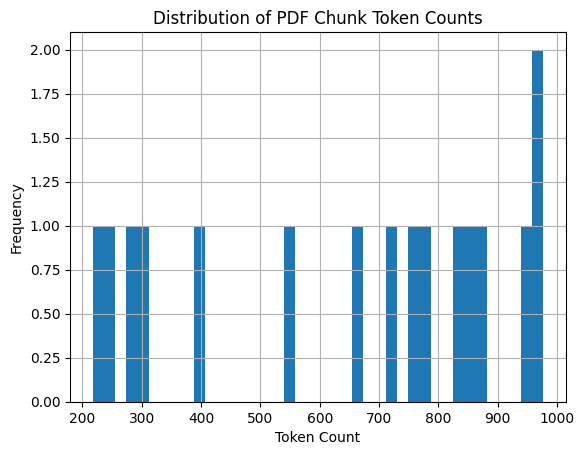

In [21]:
# Cell 14 (Actual): Visualizing Chunk Token Counts

# Import necessary libraries for data visualization (imports already in Cell 1)
import pandas as pd
import matplotlib.pyplot as plt

# Ensure `pdf_chunks` is created from a previous cell (e.g., Cell 13 Actual)
# Ensure the token counting function (`count_tokens_tiktoken`) is defined and the tokenizer is initialized
# from a previous cell (e.g., Cell 12 Actual)

print("Visualizing token count distribution of PDF chunks.")

# Create a list of token counts for each PDF chunk
# Use the updated tiktoken counting function defined earlier (e.g., in Cell 12 Actual)
if 'pdf_chunks' in locals() and pdf_chunks: # Check if pdf_chunks exists and is not empty
    token_counts = [count_tokens_tiktoken(chunk.page_content) for chunk in pdf_chunks]

    # Create a DataFrame from the token counts
    df = pd.DataFrame({'Token Count': token_counts})

    # Create a histogram of the token count distribution
    print(f"\nGenerating histogram for {len(token_counts)} chunks...")
    df.hist(bins=40) # You can adjust the number of bins

    # Set the title and labels for clarity
    plt.title('Distribution of PDF Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

    # Optional: Print descriptive statistics
    # print("\nToken count descriptive statistics:")
    # print(df.describe())

else:
    print("pdf_chunks not found or is empty. Skipping visualization.")

- **Split by pages**: If your data comes from documents organized in pages, there are methods that allow you to split data in pages to keep track of the page content. This method is specially useful when dealing with PDFs, as in the following example:

In [22]:
# Simple method - Split by pages    ________________________________________________________________________
# You need a PDF file in your environement. 
loader = PyPDFLoader("Docs/attentions.pdf")
pdf_pages_chunks = loader.load_and_split()
pdf_pages_chunks

print("\nSPLITTING BY PAGES")
print("PDF Splited by Pages - You have {0} number of chunks.".format(len(pdf_pages_chunks)))


SPLITTING BY PAGES
PDF Splited by Pages - You have 16 number of chunks.


### Vector Stores

Vector stores, also known as vector databases, are specialized types of databases designed to efficiently handle and manipulate high-dimensional vector data. In our case, we will store the tokenized and splitted content, e.g., the data chunks in the format that LLMs can process.

There are different types of vector stores. Depending on the storage of the data, we can classify them as:
- **Local Vector Stores**: This type of databases store the information in your local system. As an example of Local Vector Store, we will use FAISS.
- **Online Vector Stores**: This type of databases store the information in the cloud. We will use Pinecone as out preferred option for Online Vector Stores.

FAISS - EXAMPLE OF LOCAL VECTOR STORE

In [67]:
# Cell 15 (Actual): Creating a Local FAISS Vector Store

# Import necessary vector store and embedding components (imports already in Cell 1)
# from langchain.vectorstores import FAISS # Original import path
# from langchain.embeddings.openai import OpenAIEmbeddings # Original import path

# Modern import path for FAISS
from langchain_community.vectorstores import FAISS

# Modern import path for OpenAIEmbeddings
from langchain_openai import OpenAIEmbeddings

# Ensure `pdf_chunks` is created from a previous cell (e.g., Cell 13 Actual)
# Ensure `OPENAI_API_KEY` is loaded from environment variables (Cell 2)

print("Demonstrating creating a local FAISS vector store.")

# 1. Get or Initialize the embedding model
# Assuming embeddings instance might already exist from Cell 5, but initializing again for clarity
# Ensure OPENAI_API_KEY is loaded.
print("Initializing OpenAI Embeddings model...")
embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002", # Specify the model
    openai_api_key=OPENAI_API_KEY    # Pass the API key
)
print("Embeddings model initialized.")


# 2. Create a vector database using FAISS from documents

# Use the FAISS.from_documents class method.
# This method takes your document chunks and the embedding model,
# generates embeddings for the chunks, and builds the FAISS index.
print("\nCreating FAISS vector database from pdf_chunks...")
if 'pdf_chunks' in locals() and pdf_chunks: # Check if pdf_chunks exists and is not empty
    db_FAISS = FAISS.from_documents(pdf_chunks, embeddings)
    print("FAISS vector database created.")

    # Optional: You can save the FAISS index to disk if you want to reuse it later
    # faiss_save_path = "./my_faiss_index"
    # print(f"Saving FAISS index to {faiss_save_path}...")
    # db_FAISS.save_local(faiss_save_path)
    # print("FAISS index saved.")

    # Optional: Load a saved FAISS index
    # print(f"Loading FAISS index from {faiss_save_path}...")
    # loaded_db_FAISS = FAISS.load_local(faiss_save_path, embeddings, allow_dangerous_deserialization=True) # allow_dangerous_deserialization needed for recent versions
    # print("FAISS index loaded.")

else:
    print("pdf_chunks not found or is empty. Skipping FAISS database creation.")


# Note: This creates a local FAISS index (db_FAISS) for testing.
# Your main project uses a Pinecone index (vectorstore) initialized in Cell 6.
# Subsequent query steps might use either db_FAISS or vectorstore as the retriever.

Demonstrating creating a local FAISS vector store.
Initializing OpenAI Embeddings model...
Embeddings model initialized.

Creating FAISS vector database from pdf_chunks...
FAISS vector database created.


PINECONE - EXAMPLE OF ONLINE VECTOR STORE

In [25]:
# Cell 16 (Actual): Initializing Pinecone Client and Creating/Connecting to Index (Fixed)

# Import necessary Pinecone components (imports already in Cell 1)
# from pinecone import Pinecone, ServerlessSpec # Or PodSpec if not serverless
# import time # Needed for waiting

# Ensure PINECONE_API_KEY, PINECONE_ENVIRONMENT, PINECONE_INDEX_NAME are loaded from Cell 2

print("Initializing Pinecone client...")
# Use the Pinecone class for modern client initialization (v3+)
# Pass api_key and environment using keyword arguments
try:
    pc = Pinecone(api_key=PINECONE_API_KEY, environment=PINECONE_ENVIRONMENT)
    print("Pinecone client initialized successfully.")
except Exception as e:
    print(f"Error initializing Pinecone client: {e}")
    print("Please check your PINECONE_API_KEY and PINECONE_ENVIRONMENT.")
    # Exit or raise an error if client initialization fails
    raise e # Re-raise the exception


# Define the dimension of the embeddings (text-embedding-ada-002 is 1536)
embedding_dimension = 1536
# Define the metric (cosine similarity is common for embeddings)
metric = "cosine"

# Define the index name
# Use the index name loaded from environment variables (recommended)
index_name = PINECONE_INDEX_NAME
# Original code used index_name = "langchain" - ensure this matches your .env file or desired name

print(f"\nChecking for Pinecone index: '{index_name}'")

# --- FIX for TypeError: argument of type 'method' is not iterable ---
# Iterate through the list of index models returned by pc.list_indexes()
# to check if an index with the desired name exists.
index_exists = False
try:
    # pc.list_indexes() returns an object that is iterable, yielding IndexModel objects
    for index_model in pc.list_indexes():
        # Each IndexModel object has a 'name' attribute
        if index_model.name == index_name:
            index_exists = True
            break # Found the index, no need to check further
except Exception as e:
    print(f"Error listing Pinecone indexes: {e}")
    print("Could not verify if index exists. Please check your Pinecone connection and API key.")
    # If listing fails, we cannot reliably know if the index exists.
    # We'll assume it doesn't exist and attempt creation, which might fail if it does.
    index_exists = False


if not index_exists:
    print(f"Index '{index_name}' does not exist. Creating it...")
    # Create the index - using ServerlessSpec as an example
    # <--- IMPORTANT: Adjust the cloud and region based on your Pinecone account and plan! ---
    try:
        pc.create_index(
            name=index_name,
            dimension=embedding_dimension,
            metric=metric,
            spec=ServerlessSpec(cloud="aws", region="us-east-1") # <--- ADJUST THIS SPEC
            # If using pod-based, uncomment and adjust this:
            # spec=PodSpec(environment=PINECONE_ENVIRONMENT, pod_type="p1.x1") # <--- ADJUST THIS SPEC
        )
        # Wait for the index to be ready
        print("Waiting for index to become ready...")
        while not pc.describe_index(index_name).status.ready: # Use .status.ready in v3+
            time.sleep(1)
        print(f"Index '{index_name}' created and ready.")
    except Exception as e:
        print(f"Error creating Pinecone index '{index_name}': {e}")
        print("Please check your Pinecone account, index name, dimensions, metric, and spec.")
        # Exit or raise error if index creation fails critically
        raise e # Re-raise the exception to stop execution if index creation is essential

else:
    print(f"Index '{index_name}' already exists.")

# Connect to the index
# Get an Index object to perform data operations (upsert, query, etc.)
try:
    index = pc.Index(index_name)
    print(f"\nConnected to index '{index_name}'. Index stats:")
    # Use the index object to describe stats
    print(index.describe_index_stats())
except Exception as e:
    print(f"Error connecting to Pinecone index '{index_name}': {e}")
    print("Please ensure the index name is correct and the index is ready.")
    # Exit or raise error if index connection fails
    raise e # Re-raise the exception


# Note: The 'index' object is the direct pinecone-client interface for data operations.
# In the next step, we will use this with Langchain's PineconeVectorStore wrapper.

Initializing Pinecone client...
Pinecone client initialized successfully.

Checking for Pinecone index: 'langchain'
Index 'langchain' already exists.

Connected to index 'langchain'. Index stats:
{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}


In [29]:
# Cell 17 (Actual - Revised): Manually Embedding and Upserting Document Chunks to Pinecone

# Ensure `pdf_chunks` is created from a previous cell (e.g., Cell 13 Actual)
# Ensure `embeddings` (OpenAIEmbeddings instance) is initialized from a previous cell (e.g., Cell 15 Actual, or Cell 5 Actual)
# Ensure the direct pinecone-client `index` object is initialized and connected (from Cell 16 Actual)

print("Starting manual embedding and upserting process...")

# Define a batch size for upserting
# Pinecone recommends batching for efficiency
batch_size = 100 # Adjust based on chunk size and network; 100 is a common starting point

# Check if the index already has vectors to avoid re-upserting the same data
try:
    index_stats = index.describe_index_stats()
    print(f"Current vector count in index '{index_name}': {index_stats.total_vector_count}")

    if index_stats.total_vector_count == 0:
        print("Index appears empty. Proceeding with manual upsert.")

        # Iterate through chunks in batches
        for i in range(0, len(pdf_chunks), batch_size):
            # Get the current batch of chunks
            batch_chunks = pdf_chunks[i:i + batch_size]
            batch_end = min(i + batch_size, len(pdf_chunks))
            print(f"Processing batch {i} to {batch_end-1}...")

            # 1. Manually generate embeddings for the batch of chunks
            # embeddings.embed_documents takes a list of strings
            batch_texts = [chunk.page_content for chunk in batch_chunks]
            try:
                batch_embeddings = embeddings.embed_documents(batch_texts)
                print(f"  Generated {len(batch_embeddings)} embeddings for the batch.")
                if not batch_embeddings or len(batch_embeddings) != len(batch_chunks):
                     print(f"  Warning: Embedding batch returned unexpected results (length {len(batch_embeddings)}). Skipping upsert for this batch.")
                     continue # Skip this batch if embedding failed or was incomplete

            except Exception as e:
                print(f"  Error generating embeddings for batch {i}: {e}. Skipping upsert for this batch.")
                continue # Skip this batch if embedding failed


            # 2. Prepare data for Pinecone upsert
            # Pinecone upsert expects a list of (id, vector, metadata) tuples or dictionaries
            vectors_to_upsert = []
            for j, chunk in enumerate(batch_chunks):
                # Generate a unique ID for each chunk
                # A simple approach: combine source, page, and chunk index within the page
                # You might need a more robust ID generation strategy for large datasets
                chunk_id = f"{chunk.metadata.get('source', 'unknown')}-{chunk.metadata.get('page', 0)}-chunk{i+j}"

                # Get the corresponding embedding vector
                vector = batch_embeddings[j]

                # Get the metadata (Pinecone stores metadata as a dictionary)
                metadata = chunk.metadata # Use the existing metadata from the Document

                vectors_to_upsert.append((chunk_id, vector, metadata))

            # 3. Perform batch upsert using the direct pinecone-client index object
            if vectors_to_upsert:
                try:
                    upsert_response = index.upsert(vectors=vectors_to_upsert)
                    print(f"  Batch upsert response: {upsert_response}")
                except Exception as e:
                     print(f"  Error during Pinecone upsert for batch {i}: {e}. Continuing to next batch.")
                     # Don't raise here, try to process remaining batches
            else:
                 print(f"  No vectors prepared for upsert in batch {i}.")


        print("\nManual upsert process finished.")
        # Get final index stats via the direct pinecone client index object
        # Add a short delay to allow Pinecone stats to update
        print("Waiting for index stats to update...")
        time.sleep(10)
        print(f"Final vector count after manual upsert: {index.describe_index_stats().total_vector_count}")

        # We still need a Langchain PineconeVectorStore instance for retrieval later
        # Load the vector store instance from the existing index
        print("Initializing Langchain PineconeVectorStore from existing index...")
        vectorstore = PineconeVectorStore.from_existing_index(
            index_name=index_name,
            embedding=embeddings, # Pass the embedding model used for this index
            # You might need to pass the text_key if your metadata field name for text is not 'text'
            # text_key="page_content" # Assuming 'page_content' is stored in metadata field named 'text' by default from_documents, might need adjustment here
        )
        print("Langchain PineconeVectorStore initialized from existing index.")


    else:
        print("Index already contains vectors. Assuming data is already upserted.")
        # If index is not empty, initialize the vector store instance from the existing index
        print(f"Connecting to existing Pinecone vector store '{index_name}'...")
        vectorstore = PineconeVectorStore.from_existing_index(
            index_name=index_name,
            embedding=embeddings, # Pass the embedding model used for this index
             # text_key="page_content" # Adjust text_key if needed
        )
        print("Connected to existing vector store.")

except Exception as e:
    print(f"Error during Pinecone upsert or connection: {e}")
    print("Please check your Pinecone setup, index name, and that pdf_chunks/embeddings are correct.")
    # Exit or raise error if this critical step fails
    raise e # Re-raise the exception


# The 'vectorstore' object (an instance of PineconeVectorStore) is now ready for retrieval (similarity search).
# You will use vectorstore.as_retriever() in subsequent query steps.

Starting manual embedding and upserting process...
Current vector count in index 'langchain': 17
Index already contains vectors. Assuming data is already upserted.
Connecting to existing Pinecone vector store 'langchain'...
Connected to existing vector store.


### Testing APIs

In [27]:
# Debugging Step: Test OpenAI Embeddings separately
# Ensure 'embeddings' object is initialized from a previous cell
print("\nDebugging: Testing OpenAI Embeddings directly...")
try:
    test_texts = ["This is a test sentence.", "This is another test sentence."]
    test_vectors = embeddings.embed_documents(test_texts)
    print(f"Successfully embedded {len(test_vectors)} sentences.")
    if test_vectors:
         print(f"First test vector dimension: {len(test_vectors[0])}") # Should be 1536
         print(f"Sample: {test_vectors[0][:5]}...")
    else:
         print("Embedding returned an empty list.")
except Exception as e:
    print(f"Error during direct embedding test: {e}")
    print("Potential issue with OpenAI API key or connection for embeddings.")


Debugging: Testing OpenAI Embeddings directly...
Successfully embedded 2 sentences.
First test vector dimension: 1536
Sample: [-0.0011391325388103724, -0.003206387162208557, 0.002380132209509611, -0.004501554183661938, -0.010328996926546097]...


In [28]:
# Debugging Step: Test Pinecone Upsert directly
# Ensure 'index' object (direct pinecone-client index) is initialized from Cell 16 Actual
# Ensure 'embeddings' object is initialized from a previous cell

print("\nDebugging: Testing direct Pinecone upsert...")
try:
    # Embed a simple test string to get a valid vector
    test_string_for_upsert = "Pinecone direct upsert test."
    test_vector_for_upsert = embeddings.embed_query(test_string_for_upsert) # Use embed_query for a single string

    if test_vector_for_upsert and len(test_vector_for_upsert) == 1536: # Check if embedding succeeded
        # Define a unique ID for the test vector
        test_vector_id = "test-vector-12345"
        # Define metadata for the test vector
        test_metadata = {"source": "debug", "text": test_string_for_upsert}

        # Structure the data for upsert (list of tuples or dicts)
        vectors_to_upsert = [(test_vector_id, test_vector_for_upsert, test_metadata)] # (id, vector, metadata) format

        # Perform the upsert
        upsert_response = index.upsert(vectors=vectors_to_upsert)
        print(f"Direct Pinecone upsert response: {upsert_response}")

        # Check stats after a brief delay
        time.sleep(5) # Give Pinecone a few seconds to update stats
        updated_stats = index.describe_index_stats()
        print(f"Vector count after direct upsert test: {updated_stats.total_vector_count}")

        # Optional: Clean up the test vector
        # print("Deleting test vector...")
        # index.delete(ids=[test_vector_id])
        # time.sleep(5)
        # print(f"Vector count after deletion attempt: {index.describe_index_stats().total_vector_count}")


    else:
        print("Failed to generate test vector for direct upsert.")

except Exception as e:
    print(f"Error during direct Pinecone upsert test: {e}")
    print("Potential issue with Pinecone connection, API key, or index state.")


Debugging: Testing direct Pinecone upsert...
Direct Pinecone upsert response: {'upserted_count': 1}
Vector count after direct upsert test: 17


### Natural Language Retrieval
We first start performing a semantic search within our Vector DataBase. 

In [ ]:
# Cell 18 (Actual): Performing Semantic Search in FAISS

# Remove redundant initialization - db_FAISS and embeddings should already exist
# df = FAISS.from_documents(pdf_chunks, embeddings) # This line recreates the index, likely not intended here
# embeddings = OpenAIEmbeddings() # Embeddings should be initialized earlier

print("Performing semantic search in the FAISS vector store.")

# Define the query for semantic search
query = "Can you please tell me all the authors of the article Attention is all you need?" # <--- Your search query

# We can define how many similar results we want to get back by defining the variable k
k_value = 2 # Number of top similar documents to retrieve

# Perform the similarity search on the FAISS database
# Use the .similarity_search() method
print(f"\nSearching FAISS for top {k_value} matches for query: '{query}'")
matches = db_FAISS.similarity_search(query, k=k_value)

print(f"\nFound {len(matches)} similar document chunks:")

# Print the retrieved document chunks
if matches:
    for i, doc in enumerate(matches):
        print(f"--- Match {i+1} ---")
        print(f"Source: {doc.metadata.get('source')}, Page: {doc.metadata.get('page')}")
        # Print a snippet of the content
        print(doc.page_content[:300] + "...")
        # Optional: Print the score if available (FAISS.similarity_search doesn't return score by default)
        # If you need scores, use similarity_search_with_score
        # print(f"Score: {score}")
else:
    print("No matches found.")

Performing semantic search in the FAISS vector store.

Searching FAISS for top 2 matches for query: 'Can you please tell me all the authors of the article Attention is all you need?'

Found 2 similar document chunks:
--- Match 1 ---
Source: Docs/attentions.pdf, Page: 0
Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.
Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Par...
--- Match 2 ---
Source: Docs/attentions.pdf, Page: 13
Input-Input Layer5
The
Law
will
never
be
perfect
,
but
its
application
should
be
just
-
this
is
what
we
are
missing
,
in
my
opinion
.
<EOS>
<pad>
The
Law
will
never
be
perfect
,
but
its
application
should
be
just
-
this
is
what
we
are
missing
,
in
my
opinion
.
<EOS>
<pad>
Input-Input Layer5
The
Law
...


In the above section, we have seen how to retrieve the coincidences of you query in the documents in our vector store. Nevertheless, the output is a bit difficult to read. We can leverage the usage of LLMs by feeding the coincidences in our vector store to an LLM and let it generate a response in Natural Language using the additional information from our documents. We can do so by using the so-called **[LangChain Chains](https://python.langchain.com/docs/expression_language/get_started)**.

In [43]:
# Cell 20 (Actual): Performing RAG Q&A using Pinecone

# Remove the outdated import for load_qa_chain
# from langchain.chains.Youtubeing import load_qa_chain

# Ensure `vectorstore` (PineconeVectorStore instance) is initialized from Cell 17 Actual
# Ensure `chatgpt` or `llm` (ChatOpenAI instance) is initialized from a previous cell (e.g., Cell 3 or 4)
# Ensure necessary imports for modern chains (from Cell 1) are available:
# from langchain_core.prompts import ChatPromptTemplate
# from langchain.chains import create_retrieval_chain
# from langchain.chains.combine_documents import create_stuff_documents_chain
# from langchain_core.runnables import RunnablePassthrough, RunnableParallel # Needed for LCEL
# from langchain_core.output_parsers import StrOutputParser # Needed for LCEL

# Define a query for semantic search
query = "Can you please tell me all the authors of the article Attention is all you need?" # <--- Your search query

# We can define how many similar results we want to get back by defining the variable k
k_value = 2 # Number of top similar documents to retrieve (original code used 2, let's keep that)

# Ensure `vectorstore` (PineconeVectorStore) is initialized and ready for use
# This is the Langchain wrapper instance connected to your Pinecone index
if 'vectorstore' not in locals() or vectorstore is None:
    print("Error: Pinecone vector store (vectorstore) not found. Please run Cell 17 Actual first.")
else:
    print(f"Setting up RAG chain for Pinecone with top {k_value} matches.")

    # 1. Get a Retriever from the Pinecone Vector Store

    # Get a retriever instance from the Pinecone vector store.
    # This object is capable of performing the similarity search on Pinecone.
    # Pass k to the retriever using search_kwargs
    retriever = vectorstore.as_retriever(search_kwargs={"k": k_value})

    # You can perform the search explicitly to inspect results (optional):
    # matches = retriever.invoke(query)
    # print(f"Retrieved {len(matches)} document chunks from Pinecone.")
    # if matches:
    #     print(f"Sample match source: {matches[0].metadata.get('source')}, page: {matches[0].metadata.get('page')}")


    # 2. Define the Prompt Template for the LLM

    # This prompt instructs the LLM on how to use the retrieved context to answer the question.
    # Use ChatPromptTemplate for chat models.
    # (Import ChatPromptTemplate is already in Cell 1)
    rag_prompt_template = ChatPromptTemplate.from_messages([
        ("system", "Answer the user's question based on the below context:\n\n{context}\n\nIf the answer is not in the context, say 'I cannot answer that question based on the provided information.'"),
        ("user", "{question}")
    ])

    # 3. Create the Chain to Combine Documents and Answer using create_stuff_documents_chain

    # This utility handles formatting the list of Documents into a string for the prompt's {context}.
    # It expects 'context' (list of Docs) and 'question' (string) as input.
    # (Import create_stuff_documents_chain is already in Cell 1)
    combine_docs_chain = create_stuff_documents_chain(
        chatgpt,           # Pass your Chat LLM instance (assuming 'chatgpt' or 'llm')
        rag_prompt_template # Pass the RAG prompt template
    )

    # 4. Create the Full RAG Chain using create_retrieval_chain

    # This utility connects the retriever and the combine_docs_chain.
    # It is designed to take {"question": ...} as input, run the retriever with the query,
    # get the context, and pass {"context": [...], "question": ...} to the combine_docs_chain.
    # (Import create_retrieval_chain is already in Cell 1)
    rag_chain = create_retrieval_chain(
        retriever,          # The retriever gets the relevant documents from Pinecone
        combine_docs_chain  # The combine_docs_chain uses the documents and question to answer
    )

    print("\nRunning RAG Chain with the query...")

    # 5. Invoke the RAG Chain

    # Invoke the RAG chain with the query.
    # According to documentation and typical usage, create_retrieval_chain expects {"question": ...} as input.
    response = rag_chain.invoke({
        "input":   query,   # so you satisfy the top‐level chain
        "question": query   # so the combine prompt has its {question} value
    }) # <--- Using 'question' key


    # The response object from create_retrieval_chain is a dictionary.
    # The final answer is typically under the 'answer' key.
    # The retrieved documents are available under the 'context' key.
    print("\nAnswer:")
    # Use .get() for safe access in case 'answer' key is missing, although it should be present
    print(response.get('answer', 'No answer generated.'))

    # Also print retrieved context explicitly, as it's returned by create_retrieval_chain
    print("\nRetrieved Context:")
    if 'context' in response:
        for i, doc in enumerate(response['context']):
            print(f"--- Document {i+1} ---")
            # Print snippet and metadata for the retrieved docs
            print(doc.page_content[:200] + "...")
            print(f"Source: {doc.metadata.get('source')}, Page: {doc.metadata.get('page')}")

Setting up RAG chain for Pinecone with top 2 matches.

Running RAG Chain with the query...

Answer:
The authors of the article "Attention Is All You Need" are Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin.

Retrieved Context:
--- Document 1 ---
Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.
Attention Is All You Need
...
Source: Docs/attentions.pdf, Page: 0.0
--- Document 2 ---
Input-Input Layer5
The
Law
will
never
be
perfect
,
but
its
application
should
be
just
-
this
is
what
we
are
missing
,
in
my
opinion
.
<EOS>
<pad>
The
Law
will
never
be
perfect
,
but
its
application
sh...
Source: Docs/attentions.pdf, Page: 13.0


### Indexes and Metadata
When we upload data to our vector database, there is metadata that allows us to understand where the data is coming from. 
When dealing with PDFs, the source information allows us to know what pdf and page the info is coming from.

In [44]:
# Cell 21 (Actual): Inspecting Retrieved Documents from FAISS Search

# Ensure `db_FAISS` (FAISS vector store instance) is created from Cell 15 Actual
# Ensure `embeddings` (OpenAIEmbeddings instance) is initialized from a previous cell

print("Performing semantic search in FAISS and inspecting results.")

# Define the query for semantic search
query = "Who created transformers?" # <--- Your search query

# We can define how many similar results we want to get back by defining the variable k
# Note: Original code didn't specify k, which defaults to 4.
# However, if fewer than 4 matches are found, accessing matches[3] will cause an IndexError.
# It's best practice to specify k if you intend to access a specific index.
k_value = 4 # Set k to at least the index you intend to access (index 3 requires k>=4)

# Ensure db_FAISS exists and is ready for use
if 'db_FAISS' not in locals() or db_FAISS is None:
    print("Error: FAISS vector store (db_FAISS) not found. Please run Cell 15 Actual first.")
else:
    print(f"\nSearching FAISS for top {k_value} matches for query: '{query}'")
    # Perform the similarity search on the FAISS database using its retriever
    # Get a retriever instance from the FAISS database
    # Pass k to the retriever using search_kwargs, or directly to similarity_search if preferred
    # Using similarity_search directly as in the original code:
    matches = db_FAISS.similarity_search(query, k=k_value)


    print(f"Found {len(matches)} similar document chunks.")

    # Check if the desired match index exists before trying to access it
    target_match_index = 3 # Original code accessed index 3 (the 4th match)

    print(f"\n______________________________________ MATCH {target_match_index + 1} (Index {target_match_index})")

    if len(matches) > target_match_index:
        # Access the specific match (index 3)
        target_match = matches[target_match_index]

        # Print the chunk text content
        print("\nChunk text content:")
        print(target_match.page_content) # Use .page_content

        # Print the chunk metadata
        print("\nChunk metadata:")
        print(target_match.metadata) # Use .metadata (a dictionary)

        # Print specific metadata fields
        # Use .get() for safe access in case the key is missing
        source = target_match.metadata.get("source", "N/A")
        page = target_match.metadata.get("page", "N/A") # Assuming 'page' is the key for page number
        print(f"\nThe source of our match is: {source}, and page: {page}")

    else:
        print(f"Error: Fewer than {k_value} matches found. Cannot access match at index {target_match_index}.")
        print(f"Only {len(matches)} matches were returned.")

Performing semantic search in FAISS and inspecting results.

Searching FAISS for top 4 matches for query: 'Who created transformers?'
Found 4 similar document chunks.

______________________________________ MATCH 4 (Index 3)

Chunk text content:
1 Introduction
Recurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks
in particular, have been firmly established as state of the art approaches in sequence modeling and
transduction problems such as language modeling and machine translation [ 35, 2, 5]. Numerous
efforts have since continued to push the boundaries of recurrent language models and encoder-decoder
architectures [38, 24, 15].
Recurrent models typically factor computation along the symbol positions of the input and output
sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden
states ht, as a function of the previous hidden state ht−1 and the input for position t. This inherently
sequential nature pr

Now it is the time to put it all together and generate a simple pipeline to query our documents using a LLM model. 

# PART 2: Loading and processing our documents



PyPDFDirectoryLoader allows us to upload multiple PDFs at once. In our case, we have two PDFs in the Docs directory.

## **STEP 1 - LOADER**

Use the `PDFDirectoryLoader` to upload all PDFs contained within the the Docs folder. 

In [45]:
# Cell X: Load Documents from a Directory

# Import the necessary loader using its modern path
from langchain_community.document_loaders import PyPDFDirectoryLoader

print("Loading documents from a directory using PyPDFDirectoryLoader.")

# Define the path to your directory containing PDFs
# <--- IMPORTANT: CHANGE THIS PATH to YOUR directory containing PDFs ---
pdf_directory_path = "Docs/" # Example path from original code

print(f"Loading content from directory: {pdf_directory_path}")

try:
    # Initialize the PyPDFDirectoryLoader
    loader = PyPDFDirectoryLoader(pdf_directory_path)

    # Load documents from the directory. This returns a list of Document objects.
    # Each Document will typically be a page from one of the PDFs in the directory.
    data = loader.load() # Using 'data' as the variable name as in your snippet

    print(f"Successfully loaded {len(data)} document pages from directory {pdf_directory_path}.")

    # Inspect the loaded data (optional)
    # if data:
    #     print("\nFirst loaded document snippet:")
    #     print(f"Source: {data[0].metadata.get('source')}, Page: {data[0].metadata.get('page')}")
    #     print(data[0].page_content[:500] + "...") # Print first 500 chars
    # else:
    #      print("No data was loaded from the directory.")

except FileNotFoundError:
    print(f"Error: The directory '{pdf_directory_path}' was not found.")
except Exception as e:
    print(f"Error loading PDFs from directory: {e}")

# The 'data' variable now holds the list of Document objects loaded from the PDFs.
# This list will be used in subsequent steps for splitting, embedding, etc.

Loading documents from a directory using PyPDFDirectoryLoader.
Loading content from directory: Docs/
Successfully loaded 101 document pages from directory Docs/.


## **STEP 2 - CHUNKING**

Generate the chunks for the PDFs contained in the directory. 
1. Import both RecursiveCharacterTextSplitter from langchain.text_splitter and GPT2TokenizerFast from transformers. 
2. Define a tokenizer with the following command: tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
3. Define a count_tokens function that will allow us to count the tokens of out text. 
4. Define the text_splitter with a chunk_size of 200, a chunk_overlap of 20 and the length_function we have just defined. 
5. Apply the command `.split_documents`to our data. 

In [46]:
# Cell X: Chunking Our Data

# Import necessary components (imports already in Cell 1)
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from transformers import GPT2TokenizerFast # Original import - we'll use tiktoken instead
import tiktoken # Recommended tokenizer for OpenAI models

# Ensure `data` is loaded from the previous cell (Step 1 in this section)

print("Chunking loaded document data.")

# Use tiktoken for token counting with OpenAI models
# Get the tokenizer encoding for the embedding model you plan to use (e.g., text-embedding-ada-002)
# 'cl100k_base' is common for modern OpenAI models
try:
    tokenizer = tiktoken.get_encoding("cl100k_base")
    print("tiktoken tokenizer initialized for chunking.")
except Exception as e:
    print(f"Error initializing tiktoken tokenizer: {e}")
    print("Falling back to character count for splitting.")
    tokenizer = None # Set to None if initialization fails

# Create function to count tokens using tiktoken
def count_tokens_tiktoken(text: str) -> int:
    if tokenizer:
        tokens = tokenizer.encode(text, disallowed_special=())
        return len(tokens)
    return len(text) # Fallback to character count if tiktoken failed


# Define the splitter
# Use chunk_size and chunk_overlap in tokens
chunk_size = 200 # Example size from original code - adjust as needed
chunk_overlap = 20 # Example overlap from original code - adjust as needed

print("\nInitializing RecursiveCharacterTextSplitter...")
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=count_tokens_tiktoken if tokenizer else len, # Use tiktoken function if available, else len
    separators=["\n\n", "\n", ". ", " ", ""] # Common separators
)

# Apply the .split_document command
if 'data' in locals() and data: # Check if data variable exists and is not empty
    print(f"\nSplitting {len(data)} document pages into chunks...")
    chunks = text_splitter.split_documents(data)
    print(f"Chunking complete - Now you have {len(chunks)} number of chunks.")

    # Optional: Inspect a chunk
    # if chunks:
    #     print("\nFirst chunk snippet:")
    #     print(chunks[0].page_content[:500] + "...")
    #     print(f"Metadata: {chunks[0].metadata}")
    #     print(f"Token count (tiktoken): {count_tokens_tiktoken(chunks[0].page_content)}")
else:
    print("data not found or is empty. Skipping chunking.")

# The 'chunks' variable now holds the list of Document objects representing the text chunks.

Chunking loaded document data.
tiktoken tokenizer initialized for chunking.

Initializing RecursiveCharacterTextSplitter...

Splitting 101 document pages into chunks...
Chunking complete - Now you have 584 number of chunks.


## **STEP 3 - EMBEDD AND UPLOAD THE DATA INTO A VECTORSTORE**

**TASK**
- Upload the data into the FAISS vector store using the `from_documents`command. 

In [47]:
# Cell X: Embed and Upload Data into FAISS Vector Store

# Import necessary vector store component (import already in Cell 1 or 15)
# from langchain.vectorstores import FAISS # Original import path
from langchain_community.vectorstores import FAISS # Modern import path

# Ensure `chunks` is created from the previous cell (Step 2 in this section)
# Ensure `embeddings` (OpenAIEmbeddings instance) is initialized from a previous cell (e.g., Cell 5 Actual, or 15 Actual)

print("Creating FAISS vector store from chunks and testing semantic search.")

# ___________________________________________________________________________ LOCAL VERSION (FAISS)

# 1. Create vector database with FAISS
# Use the FAISS.from_documents class method.
# This method generates embeddings for the chunks using the provided embeddings model
# and builds the FAISS index.
print("\nCreating FAISS vector database from chunks...")
if 'chunks' in locals() and chunks and 'embeddings' in locals() and embeddings:
    db_FAISS = FAISS.from_documents(chunks, embeddings)
    print("FAISS vector database created (db_FAISS).")

    # Optional: You can save the FAISS index to disk if you want to reuse it later
    # faiss_save_path = "./my_faiss_chunks_index"
    # print(f"Saving FAISS index to {faiss_save_path}...")
    # db_FAISS.save_local(faiss_save_path)
    # print("FAISS index saved.")

    # 2. Check similarity search is working
    # Define a query
    query = "Who created transformers?" # <--- Your test query

    # Perform the semantic search in our vector database with the similarity_search command.
    # We can define how many similarities we want to get back by defining the variable k
    k_value = 4 # Number of top similarities to get

    print(f"\nTesting similarity search with query: '{query}'")
    matches = db_FAISS.similarity_search(query, k=k_value) # Specify k here


    print(f"We found {len(matches)} number of similarities.")
    # Print the content of the top matches
    if matches:
        print("Top matches:")
        # Limit the printout for brevity
        for i, match in enumerate(matches):
             print(f"\n--- Match {i+1} ---")
             print(f"Source: {match.metadata.get('source')}, Page: {match.metadata.get('page')}")
             print(match.page_content[:300] + "...") # Print first 300 chars
    else:
        print("No matches found in FAISS search.")

else:
    print("Chunks or Embeddings not found or are empty. Skipping FAISS database creation and search test.")

# The 'db_FAISS' variable now holds the FAISS vector store instance.

Creating FAISS vector store from chunks and testing semantic search.

Creating FAISS vector database from chunks...
FAISS vector database created (db_FAISS).

Testing similarity search with query: 'Who created transformers?'
We found 4 number of similarities.
Top matches:

--- Match 1 ---
Source: Docs\codex.pdf, Page: 15
training of deep bidirectional transformers for language under-
standing. arXiv preprint arXiv:1810.04805, 2018.
Dhariwal, P., Jun, H., Payne, C., Kim, J. W., Radford, A., and
Sutskever, I. Jukebox: A generative model for music. arXiv
preprint arXiv:2005.00341, 2020.
Drain, D., Wu, C., Svyatkovskiy,...

--- Match 2 ---
Source: Docs\attentions.pdf, Page: 0
training for 3.5 days on eight GPUs, a small fraction of the training costs of the
best models from the literature. We show that the Transformer generalizes well to
other tasks by applying it successfully to English constituency parsing both with
large and limited training data.
∗Equal contribution....

--- Match 3 --

# PART 3: Talking with our documents

## STEP 4 - DEFINE A CHAIN AND PERFORM THE SIMILARITY SEARCH
Generating a simple pipeline to query our documents with a load_qa_chain. 
**TASK**
1. Import the `load_qa_chain`from the langchain.chains.question_answering library. 
2. Define a prompt of interest, like: "Can you please tell me all the autors of the article Attention is all you need?"
3. Define the chain.
4. Perform a semantic search with the `.similarity_search`. 
5. Execute the chain. 

In [49]:
# Cell X: Basic RAG Q&A using FAISS (load_qa_chain Update)

# Remove the outdated import for load_qa_chain
# from langchain.chains.Youtubeing import load_qa_chain

# Ensure `db_FAISS` (FAISS vector store instance) is created from a previous cell (e.g., Step 3 in this section)
# Ensure `chatgpt` or `llm` (ChatOpenAI instance) is initialized from a previous cell (e.g., Cell 3 or 4 Actual)
# Ensure necessary imports for modern chains (from Cell 1) are available:
# from langchain_core.prompts import ChatPromptTemplate
# from langchain.chains import create_retrieval_chain
# from langchain.chains.combine_documents import create_stuff_documents_chain
# from langchain_core.runnables import RunnablePassthrough, RunnableParallel, RunnableLambda # Needed for LCEL
# from langchain_core.output_parsers import StrOutputParser # Needed for LCEL

print("Setting up and running Basic RAG Q&A using FAISS.")

# 1. Define a query of interest.
query = "Can you please tell me all the autors of the article Attention is all you need?" # <--- Your search query

# We can define how many similar results we want to get back by defining the variable k
k_value = 1 # Number of top similar documents to retrieve (original code used 1)

# Ensure db_FAISS exists and is ready for use
if 'db_FAISS' not in locals() or db_FAISS is None:
    print("Error: FAISS vector store (db_FAISS) not found. Please run the cell creating db_FAISS first.")
elif 'chatgpt' not in locals() or chatgpt is None:
     print("Error: ChatOpenAI model (chatgpt) not found. Please run a cell initializing chatgpt first.")
else:
    print(f"\nPerforming semantic search in FAISS for top {k_value} matches for query: '{query}'")

    # Get a retriever instance from the FAISS database, configured with k
    retriever = db_FAISS.as_retriever(search_kwargs={"k": k_value})

    # You can perform the search explicitly to inspect results (optional):
    # matches = retriever.invoke(query)
    # print(f"Retrieved {len(matches)} document chunks from FAISS.")
    # if matches:
    #     print(f"Sample match source: {matches[0].metadata.get('source')}, page: {matches[0].metadata.get('page')}")


    # --- Replacing load_qa_chain with modern LCEL-based RAG Chain ---

    # 2. Define the Prompt Template for the LLM
    # This prompt instructs the LLM on how to use the retrieved context to answer the question.
    # Use ChatPromptTemplate for chat models.
    # (Import ChatPromptTemplate is already in Cell 1)
    rag_prompt_template = ChatPromptTemplate.from_messages([
        ("system", "Answer the user's question based on the below context:\n\n{context}\n\nIf the answer is not in the context, say 'I cannot answer that question based on the provided information.'"),
        ("user", "{question}")
    ])

    # 3. Create the Chain to Combine Documents and Answer using create_stuff_documents_chain
    # This utility handles formatting the list of Documents into a string for the prompt's {context}.
    # It expects 'context' (list of Docs) and 'question' (string) as input.
    # (Import create_stuff_documents_chain is already in Cell 1)
    combine_docs_chain = create_stuff_documents_chain(
        chatgpt,           # Pass your Chat LLM instance
        rag_prompt_template # Pass the RAG prompt template
    )

    # 4. Create the Full RAG Chain using create_retrieval_chain
    # This utility connects the retriever and the combine_docs_chain.
    # It is designed to take {"question": ...} as input, run the retriever with the query,
    # get the context, and pass {"context": [...], "question": ...} to the combine_docs_chain.
    # (Import create_retrieval_chain is already in Cell 1)
    rag_chain = create_retrieval_chain(
        retriever,          # The retriever gets the relevant documents from FAISS
        combine_docs_chain  # The combine_docs_chain uses the documents and question to answer
    )

    print("\nExecuting the RAG chain...")

    # 5. Execute the chain to obtain a response.
    # Invoke the RAG chain with the query.
    # create_retrieval_chain expects {"question": ...} as input.
    response = rag_chain.invoke({
    "input":   query,   # so you satisfy the top‐level chain
    "question": query   # so the combine prompt has its {question} value
}) # <--- Using 'question' key


    # The response object from create_retrieval_chain is a dictionary.
    # The final answer is typically under the 'answer' key.
    # The retrieved documents are available under the 'context' key.
    print("\nAnswer:")
    # Use .get() for safe access in case 'answer' key is missing, although it should be present
    print(response.get('answer', 'No answer generated.'))

    # Optional: Also print retrieved context explicitly, as it's returned by create_retrieval_chain
    # print("\nRetrieved Context:")
    # if 'context' in response:
    #     for i, doc in enumerate(response['context']):
    #         print(f"--- Document {i+1} ---")
    #         # Print snippet and metadata for the retrieved docs
    #         print(doc.page_content[:200] + "...")
    #         print(f"Source: {doc.metadata.get('source')}, Page: {doc.metadata.get('page')}")

Setting up and running Basic RAG Q&A using FAISS.

Performing semantic search in FAISS for top 1 matches for query: 'Can you please tell me all the autors of the article Attention is all you need?'

Executing the RAG chain...

Answer:
The authors of the article "Attention is all you need" are Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L. u., and Polosukhin, I.


Now that we already have a working pipeline to query our documents, we want to understand where our data is coming from.

In [50]:
# Explicitly Stating Information Sources (Modern RAG with Source Prompt)


print("Setting up RAG Q&A with source citation instruction in the prompt.")

# 1. Define a query of interest.
query = "Can you please tell me all the autors of the article Attention is all you need?" # <--- Your search query

# We can define how many similar results we want to get back by defining the variable k
k_value = 4 # Recommend k=4 or more for RAG, original used k=1 which might not provide enough context

# Ensure db_FAISS exists and is ready for use
if 'db_FAISS' not in locals() or db_FAISS is None:
    print("Error: FAISS vector store (db_FAISS) not found. Please run the cell creating db_FAISS first.")
elif 'chatgpt' not in locals() or chatgpt is None:
     print("Error: ChatOpenAI model (chatgpt) not found. Please run a cell initializing chatgpt first.")
else:
    print(f"\nSetting up RAG chain for FAISS with top {k_value} matches.")

    # Get a retriever instance from the FAISS database, configured with k
    retriever = db_FAISS.as_retriever(search_kwargs={"k": k_value})

    # --- Replacing load_qa_chain and manual metadata formatting ---

    # 2. Define the Prompt Template for the LLM with Source Citation Instruction
    # We modify the system prompt to explicitly ask the model to cite sources.
    # The combine_docs_chain will provide the context including metadata (usually formatted).
    rag_prompt_template = ChatPromptTemplate.from_messages([
        ("system", """Answer the user's question based ONLY on the below context.
Each piece of context comes from a specific source document and page.
If the answer is found in the context, provide the answer and ALSO state the source (PDF file name and page number) where you found the information.
If the answer is not in the context, state that you cannot answer based on the provided information.

Context:
{context}"""), # The combine_docs_chain populates {context}
        ("user", "{question}")
    ])

    # 3. Create the Chain to Combine Documents and Answer using create_stuff_documents_chain
    # This utility handles formatting the list of Documents (including metadata) into a string for the prompt's {context}.
    # It expects 'context' (list of Docs) and 'question' (string) as input.
    # (Import create_stuff_documents_chain is already in Cell 1)
    combine_docs_chain = create_stuff_documents_chain(
        chatgpt,           # Pass your Chat LLM instance
        rag_prompt_template # Pass the RAG prompt template with source instruction
    )

    # 4. Create the Full RAG Chain using create_retrieval_chain
    # This utility connects the retriever and the combine_docs_chain.
    # It takes {"question": ...} as input, runs the retriever, gets context, and passes both to the combine chain.
    # (Import create_retrieval_chain is already in Cell 1)
    rag_chain = create_retrieval_chain(
        retriever,          # The retriever gets the relevant documents from FAISS
        combine_docs_chain  # The combine_docs_chain uses the documents and question to answer
    )

    print("\nExecuting the RAG chain with source citation instruction...")

    # 5. Execute the chain to obtain a response.
    # Invoke the RAG chain with the query.
    # create_retrieval_chain expects {"question": ...} as input.
    response = rag_chain.invoke({
        "input": query,
        "question": query
        }) # <--- Using 'question' key


    # The response object from create_retrieval_chain is a dictionary.
    # The final answer is typically under the 'answer' key.
    # The retrieved documents are available under the 'context' key.
    print("\nAnswer:")
    # Use .get() for safe access in case 'answer' key is missing, although it should be present
    print(response.get('answer', 'No answer generated.'))

    # Optional: Also print retrieved context explicitly, as it's returned by create_retrieval_chain
    # print("\nRetrieved Context:")
    # if 'context' in response:
    #     for i, doc in enumerate(response['context']):
    #         print(f"--- Document {i+1} ---")
    #         # Print snippet and metadata for the retrieved docs
    #         print(doc.page_content[:200] + "...")
    #         print(f"Source: {doc.metadata.get('source')}, Page: {doc.metadata.get('page')}")

Setting up RAG Q&A with source citation instruction in the prompt.

Setting up RAG chain for FAISS with top 4 matches.

Executing the RAG chain with source citation instruction...

Answer:
The authors of the article "Attention is all you need" are Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin. (Source: Attention Is All You Need, p. 1747-1756)


Try to ask the model something that is completely out of scope, and see what happens!

In [51]:
# Cell X: Testing RAG Q&A with an Out-of-Scope Query

# Remove the outdated import for load_qa_chain (already removed in previous cell's update)
# from langchain.chains.Youtubeing import load_qa_chain

# Ensure `db_FAISS` (FAISS vector store instance) is created from a previous cell
# Ensure `chatgpt` or `llm` (ChatOpenAI instance) is initialized from a previous cell
# Ensure necessary imports for modern chains (from Cell 1) are available (already imported)
# from langchain_core.prompts import ChatPromptTemplate
# from langchain.chains import create_retrieval_chain
# from langchain.chains.combine_documents import create_stuff_documents_chain
# from langchain_core.runnables import RunnablePassthrough, RunnableParallel
# from langchain_core.output_parsers import StrOutputParser

print("Testing RAG Q&A with an out-of-scope query.")

# 1. Define a query of interest (out of scope).
query = "What are the main problems to cook with olive oil?" # <--- Your out-of-scope query

# We can define how many similar results we want to get back by defining the variable k
# Using k=1 as in the original code, though k=4 or higher is generally recommended for RAG
k_value = 1

# Ensure db_FAISS exists and is ready for use
if 'db_FAISS' not in locals() or db_FAISS is None:
    print("Error: FAISS vector store (db_FAISS) not found. Please run the cell creating db_FAISS first.")
elif 'chatgpt' not in locals() or chatgpt is None:
     print("Error: ChatOpenAI model (chatgpt) not found. Please run a cell initializing chatgpt first.")
else:
    print(f"\nUsing FAISS for top {k_value} matches for out-of-scope query: '{query}'")

    # Get a retriever instance from the FAISS database, configured with k
    # Note: Even for out-of-scope queries, the retriever will return *something* -
    # the documents it considers *least dissimilar* if no truly similar ones exist.
    retriever = db_FAISS.as_retriever(search_kwargs={"k": k_value})


    # --- Reusing the modern LCEL-based RAG Chain setup ---
    # The chain structure is the same as in the previous RAG Q&A cell (Step 1 in this section)
    # The prompt already includes the instruction to state if the answer is not in the context.

    # Define the Prompt Template for the LLM (same as previous RAG cells)
    # This prompt includes the instruction to state if the answer is not in the context.
    rag_prompt_template = ChatPromptTemplate.from_messages([
        ("system", """Answer the user's question based ONLY on the below context.
Each piece of context comes from a specific source document and page.
If the answer is found in the context, provide the answer and ALSO state the source (PDF file name and page number) where you found the information.
If the answer is not in the context, state that you cannot answer based on the provided information.

Context:
{context}"""),
        ("user", "{question}")
    ])

    # Create the Chain to Combine Documents and Answer
    combine_docs_chain = create_stuff_documents_chain(
        chatgpt,           # Pass your Chat LLM instance
        rag_prompt_template # Pass the RAG prompt template
    )

    # Create the Full RAG Chain
    rag_chain = create_retrieval_chain(
        retriever,          # The retriever gets the relevant documents
        combine_docs_chain  # The combine_docs_chain uses the documents and question to answer
    )

    print("\nExecuting the RAG chain with the out-of-scope query...")

    # 5. Execute the chain to obtain a response.
    # Invoke the RAG chain with the query.
    response = rag_chain.invoke({
            "input":   query,
            "question": query
        }) # <--- Using 'question' key


    # The response object from create_retrieval_chain is a dictionary.
    # The final answer is typically under the 'answer' key.
    print("\nAnswer:")
    print(response.get('answer', 'No answer generated.'))

    # Optional: Also print retrieved context to see what was actually retrieved
    print("\nRetrieved Context:")
    if 'context' in response:
        for i, doc in enumerate(response['context']):
            print(f"--- Document {i+1} ---")
            print(doc.page_content[:200] + "...")
            print(f"Source: {doc.metadata.get('source')}, Page: {doc.metadata.get('page')}")
    else:
        print("No context returned in the response.")

Testing RAG Q&A with an out-of-scope query.

Using FAISS for top 1 matches for out-of-scope query: 'What are the main problems to cook with olive oil?'

Executing the RAG chain with the out-of-scope query...

Answer:
I cannot answer that based on the provided information.

Retrieved Context:
--- Document 1 ---
bustness failure. If the subtly buggy code is sufﬁciently
out-of-distribution, we might observe that the model per-
forms worse in these cases, simply because it is thrown off
by the OOD input - it is...
Source: Docs\codex.pdf, Page: 26


In [53]:
# Cell X: Performing Semantic Search with Similarity Scores (FAISS)

print("Demonstrating semantic search with and without scores in FAISS.")

# 1. Define a query of interest.
query = "Who went to mars?" # <--- search query (out of scope example)

# We can define how many similar results we want to get back by defining the variable k
k_value = 4 # Recommend specifying k for consistency, original used default for score search

# Ensure db_FAISS exists and is ready for use
if 'db_FAISS' not in locals() or db_FAISS is None:
    print("Error: FAISS vector store (db_FAISS) not found. Please run the cell creating db_FAISS first.")
else:
    print(f"\nSearching FAISS for top {k_value} matches for query: '{query}'")

    # 2. Perform a similarity search (without scores)
    # This returns a list of Document objects.
    matches = db_FAISS.similarity_search(query, k=k_value)
    print(f"Found {len(matches)} matches using similarity_search (without scores).")
    if matches:
         print("First match (without score):")
         print(f"  Source: {matches[0].metadata.get('source')}, Page: {matches[0].metadata.get('page')}")
         print(f"  Content snippet: {matches[0].page_content[:100]}...")


    print(f"\nSearching FAISS for top {k_value} matches for query: '{query}' with scores")

    # 3. Perform a similarity search with scores
    # This returns a list of tuples, where each tuple is (Document, score).
    matches_and_scores = db_FAISS.similarity_search_with_score(query, k=k_value) # Specify k here too

    print(f"Found {len(matches_and_scores)} matches using similarity_search_with_score.")

    # Print the retrieved document chunks and their scores
    if matches_and_scores:
        print("Top matches with scores:")
        for i, (match, score) in enumerate(matches_and_scores): # Unpack the tuple
            print(f"\n--- Match {i+1} ---")
            print(f"  Score: {score}") # Print the score
            print(f"  Source: {match.metadata.get('source')}, Page: {match.metadata.get('page', 'N/A')}") # Access Document attributes
            print(f"  Content snippet: {match.page_content[:200]}...") # Access Document attributes


    else:
        print("No matches found in FAISS search with scores.")

Demonstrating semantic search with and without scores in FAISS.

Searching FAISS for top 4 matches for query: 'Who went to mars?'
Found 4 matches using similarity_search (without scores).
First match (without score):
  Source: Docs\incoder.pdf, Page: 11
  Content snippet: arXiv:2203.13474, 2022.
12...

Searching FAISS for top 4 matches for query: 'Who went to mars?' with scores
Found 4 matches using similarity_search_with_score.
Top matches with scores:

--- Match 1 ---
  Score: 0.5270625948905945
  Source: Docs\incoder.pdf, Page: 11
  Content snippet: arXiv:2203.13474, 2022.
12...

--- Match 2 ---
  Score: 0.5306929349899292
  Source: Docs\attentions.pdf, Page: 10
  Content snippet: Zhou, and Yoshua Bengio. A structured self-attentive sentence embedding. arXiv preprint
arXiv:1703.03130, 2017.
[23] Minh-Thang Luong, Quoc V . Le, Ilya Sutskever, Oriol Vinyals, and Lukasz Kaiser. Mu...

--- Match 3 ---
  Score: 0.5419189929962158
  Source: Docs\codex.pdf, Page: 14
  Content snippet: Dhar

In [55]:
print(matches[0].page_content)

arXiv:2203.13474, 2022.
12


Try other queries and talk with your documents!

In [72]:
# Cell X: Encapsulating Basic RAG Q&A in a Function (FAISS) - Debugging Check

# Ensure necessary imports for modern chains (from Cell 1) are available
# Ensure necessary imports for FAISS and Embeddings (from Cell 1 or 15) are available

print("Defining the asking_your_model function (updated with internal check).")

# Define the asking_your_model function
# This function encapsulates the RAG Q&A logic using the FAISS index.
# It takes the query string and k (number of results) as input.
# It assumes db_FAISS and chatgpt (or llm) are accessible in the scope where the function is called.
def asking_your_model(query: str, k: int):
    """
    Performs RAG Q&A using the FAISS vector store.

    Args:
        query: The user's question.
        k: The number of similar documents to retrieve.

    Returns:
        A dictionary containing the 'answer' and 'context' from the RAG chain.
    """
    # --- Debugging: Check db_FAISS state inside the function ---
    print("--- Debugging inside function ---")
    # Check if 'db_FAISS' exists in the global scope (where notebook variables live)
    if 'db_FAISS' in globals():
         print(f"db_FAISS FOUND in globals() inside function. Type: {type(globals()['db_FAISS'])}")
         # Optional: print a representation if you want more detail (can be verbose)
         # print(f"db_FAISS repr: {repr(globals()['db_FAISS'])}")
    else:
         print("db_FAISS NOT found in globals() inside function.")

    # Check if 'chatgpt' exists in the global scope
    if 'chatgpt' in globals():
         print(f"chatgpt FOUND in globals() inside function. Type: {type(globals()['chatgpt'])}")
    else:
         print("chatgpt NOT found in globals() inside function.")
    print("--- End Debugging inside function ---")


    # Ensure necessary variables are available within the function scope
    # Check in globals() instead of locals() for notebook-level variables
    # Use globals()['variable_name'] to access them explicitly
    if 'db_FAISS' not in globals() or globals()['db_FAISS'] is None:
        print("Error: FAISS vector store (db_FAISS) not found.")
        return {"answer": "Error: Vector store not initialized.", "context": []}
    # Also check chatgpt for completeness
    if 'chatgpt' not in globals() or globals()['chatgpt'] is None:
        print("Error: ChatOpenAI model (chatgpt) not found.")
        return {"answer": "Error: LLM not initialized.", "context": []}

    # --- RAG Chain Logic (using globals() to access db_FAISS and chatgpt) ---

    # 1. Get a Retriever from the FAISS Database
    # Access db_FAISS using globals()['db_FAISS']
    retriever = globals()['db_FAISS'].as_retriever(search_kwargs={"k": k})


    # 2. Define the Prompt Template for the LLM with Source Citation Instruction
    # ... (same as before - prompt definition doesn't need globals()) ...
    rag_prompt_template = ChatPromptTemplate.from_messages([
        ("system", """Answer the user's question based ONLY on the below context.
Each piece of context comes from a specific source document and page.
If the answer is found in the context, provide the answer and ALSO state the source (PDF file name and page number) where you found the information.
If the answer is not in the context, state that you cannot answer based on the provided information.

Context:
{context}"""),
        ("user", "{question}")
    ])


    # 3. Create the Chain to Combine Documents and Answer using create_stuff_documents_chain
    # Access chatgpt using globals()['chatgpt']
    combine_docs_chain = create_stuff_documents_chain(
        globals()['chatgpt'],           # Pass your Chat LLM instance
        rag_prompt_template # Pass the RAG prompt template
    )


    # 4. Create the Full RAG Chain using create_retrieval_chain
    # ... (same as before) ...
    rag_chain = create_retrieval_chain(
        retriever,          # The retriever gets the relevant documents from FAISS
        combine_docs_chain  # The combine_docs_chain uses the documents and question to answer
    )


    # 5. Execute the chain to obtain a response.
    # ... (same as before) ...
    response = rag_chain.invoke({
         "input":   query,
         "question": query
        })


    # 6. Return the response
    # ... (same as before) ...
    return response


# Optional: Example usage of the function (same as before)
# ...

Defining the asking_your_model function (updated with internal check).


In [73]:
# Cell X: Calling the Encapsulated RAG Function (Debugging Call)

# Ensure the asking_your_model function is defined from the previous cell
# Ensure db_FAISS and chatgpt (or llm) are initialized from previous cells (as needed by the function)

print("Attempting to call the asking_your_model function.")

# --- Debugging: Check db_FAISS state before the function call ---
print("--- Debugging before function call ---")
if 'db_FAISS' in globals():
    print(f"db_FAISS FOUND in globals() before function call. Type: {type(globals()['db_FAISS'])}")
    # Optional: print a representation (be careful with large objects)
    # print(f"db_FAISS repr: {repr(globals()['db_FAISS'])}")
else:
    print("db_FAISS NOT found in globals() before function call.")

if 'chatgpt' in globals():
    print(f"chatgpt FOUND in globals() before function call. Type: {type(globals()['chatgpt'])}")
else:
    print("chatgpt NOT found in globals() before function call.")

print("--- End Debugging before function call ---")


# Define the query
query = "What is functional correctness?" # <--- Your query

# Define the number of documents to retrieve
k_value = 4 # <--- Number of documents to retrieve

# Call the asking_your_model function with the query and k
print("\nCalling the asking_your_model function...")
response = asking_your_model(query, k=k_value)

# Print the response
print("\nFull response dictionary:")
print(response)

# You can access the answer and context keys separately
print("\nAnswer:")
print(response.get('answer', 'No answer generated.'))

Attempting to call the asking_your_model function.
--- Debugging before function call ---
db_FAISS FOUND in globals() before function call. Type: <class 'langchain_community.vectorstores.faiss.FAISS'>
chatgpt FOUND in globals() before function call. Type: <class 'langchain_openai.chat_models.base.ChatOpenAI'>
--- End Debugging before function call ---

Calling the asking_your_model function...
--- Debugging inside function ---
db_FAISS FOUND in globals() inside function. Type: <class 'langchain_community.vectorstores.faiss.FAISS'>
chatgpt FOUND in globals() inside function. Type: <class 'langchain_openai.chat_models.base.ChatOpenAI'>
--- End Debugging inside function ---

Full response dictionary:
{'input': 'What is functional correctness?', 'question': 'What is functional correctness?', 'context': [Document(id='a9fed2fb-232f-4501-acd2-e164b6417cc6', metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2023-08-03T00:07:29+00:00', 'author': '', 'key

In [74]:
# Check similarity search is working
query = "What is functional correctness?"
response = asking_your_model(query, k=4)
print(response)

--- Debugging inside function ---
db_FAISS FOUND in globals() inside function. Type: <class 'langchain_community.vectorstores.faiss.FAISS'>
chatgpt FOUND in globals() inside function. Type: <class 'langchain_openai.chat_models.base.ChatOpenAI'>
--- End Debugging inside function ---
{'input': 'What is functional correctness?', 'question': 'What is functional correctness?', 'context': [Document(id='a9fed2fb-232f-4501-acd2-e164b6417cc6', metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2023-08-03T00:07:29+00:00', 'author': '', 'keywords': '', 'moddate': '2023-08-03T00:07:29+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': 'Docs/attentions.pdf', 'total_pages': 15, 'page': 14, 'page_label': '15', 'text': 'Input-Input Layer5\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe

In [ ]:
# Check similarity search is working
query = "What is the multi-head attention in a transformer?"
response = asking_your_model(query, k=4)
print(response["answer"])

--- Debugging inside function ---
db_FAISS FOUND in globals() inside function. Type: <class 'langchain_community.vectorstores.faiss.FAISS'>
chatgpt FOUND in globals() inside function. Type: <class 'langchain_openai.chat_models.base.ChatOpenAI'>
--- End Debugging inside function ---
Multi-head attention in a transformer involves linearly projecting the queries, keys, and values multiple times with different learned linear projections to different dimensions. These projected versions are then used to perform the attention function in parallel, resulting in multiple sets of values. This allows the model to jointly attend to information from different representation subspaces at different positions. Each set of values is concatenated and projected again to produce the final values. This information can be found in the document "Attention Is All You Need" on page 4.


: 